# Deep Learning group assignment
Group name: Angry Birds

Group members:
- Nienke Reijnen: 2117034
- Andrea Ciavatti: 2115635
- Niels Boonstra: 1451294
- Yannick Lankhorst: 2052754
- Thom Zoomer:2059225
- Anne Barnasconi: 2053988

## Setting up the environment

Before running, make sure to also have installed the following packages (according to lab 8 instructions):
- pip install imageio
- pip install future
- pip install tensorboard

In [ ]:
import os
import json
import shutil
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
import json
from PIL import Image
from tqdm import tqdm
import random
from torchvision.transforms import functional
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
from ultralytics import YOLO
%matplotlib inline

In [2]:
device, device_name = (torch.device("cuda"), torch.cuda.get_device_name(0)) if torch.cuda.is_available() else (torch.device("cpu"), "CPU")
print(f"Device: {device}, {device_name}")

Device: cuda, NVIDIA GeForce RTX 3060 Laptop GPU


## Data loading & preprocessing

- DONE Correct implementation of data loaders for images and annotations for your specific object detection model
- DONE Use of data augmentation techniques
- DONE Appropriate shuffling  and batching of data
- TO DO: Conduct an online search for relevant open-source datasets, and if you can find them, use them in your application as additional training data (to improve generalization)

### The code below needs to be run on your own laptop to convert the names of the scare_crow dataset

In [23]:
# Define base directory and dataset splits
base_dir = "scarecrow_dataset"
splits = ["train", "val", "test"]

# Allowed image extensions (all lowercased for matching)
image_extensions = (".png", ".jpg", ".jpeg")

for split in splits:
    print(f"\n Processing {split} split...")
    
    image_dir = os.path.join(base_dir, split, "images")
    annotation_path = os.path.join(base_dir, split, "annotations.json")

    # Get image files (case-insensitive extension check)
    image_files = sorted([
        f for f in os.listdir(image_dir)
        if os.path.splitext(f)[1].lower() in image_extensions
    ])

    print(f" Found {len(image_files)} image files in '{split}/images'")

    # Load annotations
    with open(annotation_path, "r") as f:
        annotations = json.load(f)

    print(f" Found {len(annotations)} annotation entries in annotations.json")

    # Ensure lengths match
    if len(image_files) != len(annotations):
        print(f"  WARNING: Number of images ≠ number of annotations in {split}")
        min_len = min(len(image_files), len(annotations))
        print(f" Truncating to {min_len} entries to avoid mismatch.")
        image_files = image_files[:min_len]
        annotations = annotations[:min_len]
    else:
        min_len = len(image_files)

    # Detect if already renamed
    expected_prefix = f"{split}_original_"
    already_renamed = all(f.startswith(expected_prefix) for f in image_files)

    if already_renamed:
        print(f" Skipping {split} — already renamed.")
        continue

    # Perform renaming
    for idx, old_name in enumerate(image_files, 1):
        print(str(idx)+ ' old_name= ' + old_name)
        ext = os.path.splitext(old_name)[1]
        new_name = f"{split}_original_{idx}{ext.lower()}"
        old_path = os.path.join(image_dir, old_name)
        new_path = os.path.join(image_dir, new_name)
        #os.rename(old_path, new_path)
        image_files[idx - 1] = new_name  # Update name in list
        break
    # Update annotations
    for idx, entry in enumerate(annotations):
        print(entry)
        print(idx)
        entry["OriginalFileName"] = image_files[idx]
        break
    # Save updated annotations
    with open(annotation_path, "w") as f:
        #json.dump(annotations, f, indent=4)

        print(f" {split} renamed and annotations updated.")



 Processing train split...
 Found 263 image files in 'train/images'


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### Data loading & augmentation

In [17]:
######################################
### Defining a CustomDataset class ###
######################################


class CustomDataset(Dataset):
    def __init__(self, data_path, transform = None):
        """
        Initialize the custom dataset.
        Works for both the train data and the test data.
        """
        self.images_dir = os.path.join(data_path, "images")
        self.transform = transform
        annotations_file = data_path + "/annotations.json"
        with open(annotations_file, 'r') as f:
            annotations_list = json.load(f)
       
        # We need to extract the bounding boxes of the annotations from the JSON file and store them as [x_min, y_min, x_max, y_max] tensors
        self.data = []
        for entry in annotations_list:
            image_name = entry['OriginalFileName']
            annotation_data = entry['AnnotationData']
            bird_boxes = self.extract_bird_boxes(annotation_data)
            self.data.append({'imagename': image_name, 'bird_boxes_tensor': bird_boxes})

        # Note: we should not load all the images into a tensor here, as it would take too much memory. We load images into a tensor in the __getitem__ method.


    def extract_bird_boxes(self, annotation_data):
        """
        Extract the coordinates of the birds from the annotation data in the JSON file and return it as a tensor.
        """
        bird_boxes = []
        for entry in annotation_data:
            if entry['Label'] == 'Bird':
                coordinates_list = entry['Coordinates']
                x_coordinates = [point['X'] for point in coordinates_list]
                y_coordinates = [point['Y'] for point in coordinates_list]
                x_min, x_max = min(x_coordinates), max(x_coordinates)
                y_min, y_max = min(y_coordinates), max(y_coordinates)
                bird_boxes.append([x_min, y_min, x_max, y_max])

        return torch.tensor(bird_boxes, dtype=torch.float32) # Shape: (num_birds, 4)


    def __len__(self):
        """
        Return the size of the dataset, i.e. the number of images.
        """
        return len(self.data)


    def __getitem__(self, index):
        """
        Load an image and its corresponding annotations.
        Returns the image and a target dictionary with bounding boxes and labels (we need this for compatiblity with object detection models like Faster R-CNN)
        """
        item = self.data[index]
        image_path = os.path.join(self.images_dir, item['imagename'])
        image = Image.open(image_path).convert("RGB")
        
        bird_boxes = item['bird_boxes_tensor']
        labels = torch.ones((bird_boxes.shape[0],), dtype=torch.int64) # Assuming all the labels are 'Bird' --> we assign this to class 1
        target = {'boxes': bird_boxes, 'labels': labels} # should contain the bounding boxes and the labels

        # Apply data augmentations
        if self.transform:
            image, target = self.transform(image, target)

        return image, target


In [18]:
###############################################
### Finding the mean and std of the dataset ###
###############################################

def calculate_mean_and_std(dataset):
    # Initialize sums for mean and variance
    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_pixels = 0

    # Use tqdm to add a progress bar
    for image, _ in tqdm(dataset, desc="Calculating Mean and Std", unit="image"):
        # Convert image to tensor if it is in PIL format
        image = transforms.ToTensor()(image)  # shape: (C, H, W)
        
        # Calculate the sum and squared sum of pixels for each channel
        mean += image.mean([1, 2])  # mean per channel (C,)
        std += image.std([1, 2])    # std per channel (C,)
        num_pixels += 1
    
    # Average the sums to get the mean and std
    mean /= num_pixels
    std /= num_pixels
    
    return mean, std

# For now, do no transformations:
train_data_original = CustomDataset("scarecrow_dataset/train", transform=None)
train_data_extra = CustomDataset("bird-detection-farm/train", transform=None)

train_data = torch.utils.data.ConcatDataset([train_data_original, train_data_extra])

mean, std = calculate_mean_and_std(train_data)
print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")


Calculating Mean and Std:  29%|██▉       | 112/381 [03:04<07:22,  1.65s/image] 


KeyboardInterrupt: 

Dataset Mean: tensor([0.5390, 0.5306, 0.4421])

Dataset Std: tensor([0.1624, 0.1527, 0.1647])

### With the extra data

Dataset Mean: tensor([0.5409, 0.5505, 0.3894])

Dataset Std: tensor([0.1674, 0.1557, 0.1689])

In [6]:
#############################################
### Defining a CustomTransformation class ###
##############################################

random.seed(7)
torch.manual_seed(7)
mean = [0.5409, 0.5505, 0.3894]
std = [0.1674, 0.1557, 0.1689]

class CustomTransformation:
    def __init__(self):
        self.transforms = transforms.Compose([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean, std)])
        

    def perform_horizontal_flip(self, image, target, prob = 0.25):
        """
        Horizontally flips the image with a given probability, default is 0.25
        """
        flip_prob = prob
        if random.random() < flip_prob:
            # Flip the image
            image = functional.hflip(image)

            # Flip the bounding boxes
            boxes = target['boxes']
            width, _ = image.size
            x_min = boxes[:, 0].clone()
            x_max = boxes[:, 2].clone()
            boxes[:, 0] = width - x_max
            boxes[:, 2] = width - x_min
        
        return image, target
    

    def perform_vertical_flip(self, image, target, prob = 0.25):
        """
        Vertically flips the image with a given probability, default is 0.25
        """
        flip_prob = prob
        if random.random() < flip_prob:
            # Flip the image
            image = functional.vflip(image)

            # Flip the bounding boxes
            boxes = target['boxes']
            _, height = image.size
            y_min = boxes[:, 1].clone()
            y_max = boxes[:, 3].clone()
            boxes[:, 1] = height - y_max
            boxes[:, 3] = height - y_min
            target['boxes'] = boxes

        return image, target
    

    def perform_random_rotation(self, image, target, prob = 0.25):
        """
        Perform a random rotation in multiples of 90 degrees with a given probability, default is 0.25.
        """
        if random.random() < prob:
            angle = random.choice([90, 180, 270])

            image = functional.rotate(image, angle)

            boxes = target['boxes']
            width, height = image.size

            if angle == 90:
                boxes = boxes[:, [1, 0, 3, 2]] # swap x and y coordinates
                boxes[:, [0, 2]] = height - boxes[:, [2, 0]] # adjut x-coordinates because the rotation changes the origin
            elif angle == 180:
                boxes[:, [0, 2]] = width - boxes[:, [2, 0]] # adjust x-coordinates
                boxes[:, [1, 3]] = height - boxes[:, [3, 1]] # adjust y-coordinates
            elif angle == 270:
                boxes = boxes[:, [1, 0, 3, 2]] # swap x and y coordinates
                boxes[:, [1, 3]] = width - boxes[:, [3, 1]] # adjust y-coordinates because the rotation changes to origin
            target['boxes'] = boxes
        
        return image, target


    def perform_random_resize(self, image, target, scale_range=(0.75, 1.25)):
        """
        Perform a random reize within the specified scale range, default scale range is (0,75, 1.25)
        """
        scale = random.uniform(*scale_range)

        # Resize the image
        width, height = image.size
        new_height, new_width = int(height * scale), int(width * scale)
        image = functional.resize(image, [new_height, new_width])
        
        # Resize the boxes
        boxes = target['boxes']
        boxes = boxes * scale
        target['boxes'] = boxes
        
        return image, target


    def __call__(self, image, target):
        """
        Apply the transformations to an image
        """
        image, target = self.perform_horizontal_flip(image, target)
        image, target = self.perform_vertical_flip(image, target)
        image, target = self.perform_random_rotation(image, target)
        image, target = self.perform_random_resize(image, target)
        image = self.transforms(image)
        return image, target

In [7]:
batch_size = 32

# Define paths
train_data_original_path = "scarecrow_dataset/train"
test_data_original_path = "scarecrow_dataset/test"
val_data_original_path = "scarecrow_dataset/val"
train_data_extra_path = "bird-detection-farm/train"
valid_data_extra_path = "bird-detection-farm/valid"
test_data_extra_path = "bird-detection-farm/test"

# Loading the datasets with the transformations
transform = CustomTransformation()

train_data_original = CustomDataset(train_data_original_path, transform)
valid_data_original = CustomDataset(val_data_original_path, transform)
test_data_original = CustomDataset(test_data_original_path, transform)

train_data_extra = CustomDataset(train_data_extra_path, transform)
valid_data_extra = CustomDataset(valid_data_extra_path, transform)
test_data_extra = CustomDataset(test_data_extra_path, transform)

# Split old training set into train/val
#train_data_original, valid_data_original = torch.utils.data.random_split(train_data_original, [0.8, 0.2])

# Combine datasets
train_data = torch.utils.data.ConcatDataset([train_data_original, train_data_extra])
valid_data = torch.utils.data.ConcatDataset([valid_data_original, valid_data_extra])
test_data = torch.utils.data.ConcatDataset([test_data_original, test_data_extra])

# Loaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
# No shuffling for validation and test data because we want consistnt order for reproducibility:
val_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [ ]:
#this changes the annations format to Txt which Yolo can read. 
def convert_to_yolo_format(data_path, annotations_file, output_dir):
    # Load annotations JSON file
    with open(annotations_file, 'r') as f:
        annotations_list = json.load(f)

    # Ensure output directories exist
        os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

    #dit moest blijkbaar
    class_map = {"Bird": 0}

    # ocess each image
    for entry in annotations_list:
        image_name = entry['OriginalFileName']
        annotation_data = entry['AnnotationData']


        # Load image to get width and height
        image_path = os.path.join(data_path, 'images', image_name)
        with Image.open(image_path) as img:
            img_width, img_height = img.size
            #print(f"Image size: {img_width} x {img_height}")

        # Create the label file for this image
        label_file = os.path.join(output_dir, 'labels', os.path.splitext(image_name)[0] + '.txt')

        with open(label_file, 'w') as label_f:
            for obj in annotation_data:
                class_name = obj['Label']  # 'Label' field in your data
                print(f"Class name: {class_name}")
                if class_name in class_map:
                    # Get the coordinates (bounding box)
                    coordinates = obj['Coordinates']
                    
                    # Calculate bounding box (x_min, y_min, width, height)
                    x_min = min([coord['X'] for coord in coordinates])
                    y_min = min([coord['Y'] for coord in coordinates])
                    x_max = max([coord['X'] for coord in coordinates])
                    y_max = max([coord['Y'] for coord in coordinates])

                    # YOLO format: class_id x_center y_center width height (all normalized)
                    class_id = class_map[class_name]
                    x_center = (x_min + x_max) / 2 / img_width
                    y_center = (y_min + y_max) / 2 / img_height
                    norm_width = (x_max - x_min) / img_width
                    norm_height = (y_max - y_min) / img_height
                    
                    # Write the YOLO annotation to the label file
                    label_f.write(f"{class_id} {x_center} {y_center} {norm_width} {norm_height}\n")
                    
           
        print("printed:"+image_name)
        
    
    

data_path = "./scarecrow_dataset/val"  # Path to the train folder
annotations_file = "./scarecrow_dataset/val/annotations.json"  # Path to annotations.json
output_dir = "./scarecrow_dataset/val"  # Output directory for YOLO annotations
#convert_to_yolo_format(data_path, annotations_file, output_dir)
data_path = "./scarecrow_dataset/train"  # Path to the train folder
annotations_file = "./scarecrow_dataset/train/annotations.json"  # Path to annotations.json
#convert_to_yolo_format(data_path, annotations_file, output_dir)
data_path = "./scarecrow_dataset/test"  # Path to the train folder
annotations_file = "./scarecrow_dataset/test/annotations.json"  # Path to annotations.json
#convert_to_yolo_format(data_path, annotations_file, output_dir)


In [ ]:
model = YOLO("yolo11n.pt")  # Load YOLO model
# Example: Add dropout to YOLO layers

model.train(
    data='./scarecrow_dataset/data.yaml', # Path to dataset YAML file
    epochs=50,                          
    imgsz=640,                          
    batch=32,                           
    device=0                             # Set to 0 for GPU, 'cpu' for CPU
)

# Evaluate the model's performance on the validation set
metrics = model.val()

# Perform object detection on an image
results = model("scarecrow_dataset/test/images/20240901120856_0268_D_frame_1020 - kopie.png")  # Predict on an image
results[0].show()  # Display results
#model.save('yolov8_trained.pt') # saved yolov8s model

New https://pypi.org/project/ultralytics/8.3.126 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.124  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=C:/Users/niels/.vscode/Deeplearning/angryBirds/DL_angrybirds/scarecrow_dataset/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, class

train: Scanning C:\Users\niels\.vscode\Deeplearning\angryBirds\DL_angrybirds\scarecrow_dataset\train\labels.cache... 263 images, 20 backgrounds, 0 corrupt: 100%|██████████| 263/263 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 636.5344.7 MB/s, size: 7541.8 KB)


val: Scanning C:\Users\niels\.vscode\Deeplearning\angryBirds\DL_angrybirds\scarecrow_dataset\val\labels.cache... 32 images, 5 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<?, ?it/s]

val: C:\Users\niels\.vscode\Deeplearning\angryBirds\DL_angrybirds\scarecrow_dataset\val\images\DJI_0319.JPG: 1 duplicate labels removed


In [ ]:
# This checks all the hyperparameters and finds the best one
learning_rates = [1e-5, 1e-4, 1e-3]
batch_sizes = [32]
optimizers = ['SGD', 'Adam']
momentums = [0.9, 0.99]  # Only used for SGD
weight_decays = [1e-6, 1e-5, 1e-4]
image_sizes = [480, 640]

# Initialize YOLO model
model_path = 'yolo11n.pt'
data_path = './scarecrow_dataset/data.yaml'

# Iterate over all combinations of hyperparameters
best_map = 0
best_params = None

for lr, batch_size, optimizer, img_size, weight_decay in itertools.product(
    learning_rates, batch_sizes, optimizers, image_sizes, weight_decays
):
    # Set momentum only for SGD
    momentum = 0.9 if optimizer == 'SGD' else None

    # Initialize YOLO model
    model = YOLO(model_path)

    # Train the model
    results = model.train(
        data=data_path,
        epochs=15,
        imgsz=img_size,
        batch=batch_size,
        device=0,
        lr0=lr,
        optimizer=optimizer,
        momentum=momentum,
        weight_decay=weight_decay
    )

    # Get the metric to optimize (e.g., mAP@50)
    map50 = results.maps

    # Log the results
    print(f"lr: {lr}, batch_size: {batch_size}, optimizer: {optimizer}, img_size: {img_size}, weight_decay: {weight_decay}, mAP@50: {map50}")

    # Update the best parameters
    if map50 > best_map:
        best_map = map50
        best_params = {
            'lr': lr,
            'batch_size': batch_size,
            'optimizer': optimizer,
            'momentum': momentum,
            'weight_decay': weight_decay,
            'img_size': img_size
        }

# Print the best hyperparameters
print("Best hyperparameters:", best_params)
print("Best mAP@50:", best_map)
#Application of regularization techniques (e.g., dropout, batch normalization) 

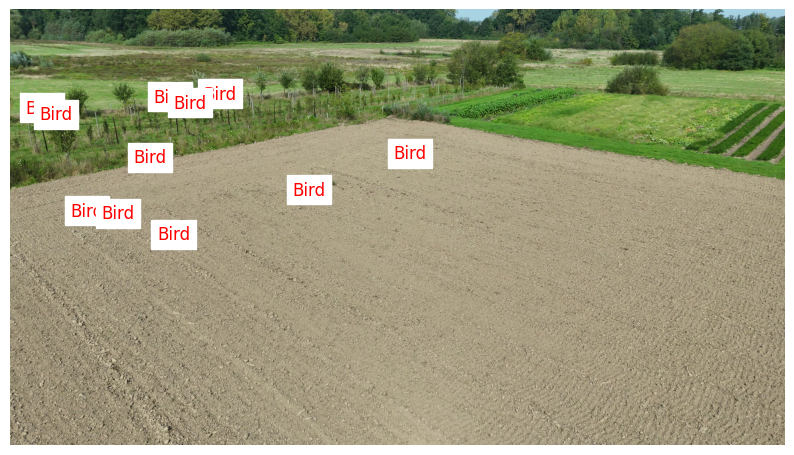

In [ ]:
#This is there to check if the Annotations are working correctly.
def visualize_yolo_annotations(image_path, label_path, class_names=None):
 
    # Load the image
    image = Image.open(image_path).convert("RGB")
    img_width, img_height = image.size

    # Create a plot
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Read the YOLO label file
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Parse each line in the label file
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])

        # Convert normalized coordinates to absolute pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculate the top-left corner of the bounding box
        x_min = x_center - (width / 2)
        y_min = y_center - (height / 2)

        # Create a rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        # Add class label (if provided)
        if class_names:
            ax.text(
                x_min, y_min - 5, class_names[class_id],
                color='red', fontsize=12, backgroundcolor='white'
            )

    plt.axis('off')
    plt.show()

# Example usage
image_path = "./scarecrow_dataset/train/images/20240901115456_0265_D_frame_1170 - kopie.png"
label_path = "./scarecrow_dataset/train/labels/20240901115456_0265_D_frame_1170 - kopie.txt"
class_names = ["Bird"]  #

visualize_yolo_annotations(image_path, label_path, class_names)